#POS himself

In [6]:
%pip install apriori_python efficient-apriori fpgrowth_py pyarmviz numpy pandas matplotlib seaborn scikit-learn matplotlib umap-learn


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
import sys
import numpy as np

class PSO:

    def __init__(self, particles, velocities, fitness_function,
                 w=0.8, c_1=1, c_2=1, max_iter=100, auto_coef=True):
        self.particles = particles
        self.velocities = velocities
        self.fitness_function = fitness_function

        self.N = len(self.particles)
        self.w = w
        self.c_1 = c_1
        self.c_2 = c_2
        self.auto_coef = auto_coef
        self.max_iter = max_iter

        self.extremums = []


        self.p_bests = self.particles
        self.p_bests_values = self.fitness_function(self.particles)
        self.g_best = self.p_bests[0]
        self.g_best_value = self.p_bests_values[0]
        self.update_bests()

        self.iter = 0
        self.is_running = True
        self.update_coef()

    def __str__(self):
        return f'[{self.iter}/{self.max_iter}] $w$:{self.w:.3f} - $c_1$:{self.c_1:.3f} - $c_2$:{self.c_2:.3f}'

    def next(self):
        if self.iter > 0:
            self.move_particles()
            self.update_bests()
            self.update_coef()

        self.iter += 1
        self.is_running = self.is_running and self.iter < self.max_iter
        return self.is_running

    def update_coef(self):
        if self.auto_coef:
            t = self.iter
            n = self.max_iter
            self.w = (0.4/n**2) * (t - n) ** 2 + 0.4
            self.c_1 = -3 * t / n + 3.5
            self.c_2 =  3 * t / n + 0.5

    def move_particles(self):

        # add inertia
        new_velocities = self.w * self.velocities
        # add cognitive component
        r_1 = np.random.random(self.N)
        r_1 = np.tile(r_1[:, None], (1, 2))
        new_velocities += self.c_1 * r_1 * (self.p_bests - self.particles)
        # add social component
        r_2 = np.random.random(self.N)
        r_2 = np.tile(r_2[:, None], (1, 2))
        g_best = np.tile(self.g_best[None], (self.N, 1))
        new_velocities += self.c_2 * r_2 * (g_best  - self.particles)

        self.is_running = np.sum(self.velocities - new_velocities) != 0

        # update positions and velocities
        self.velocities = new_velocities
        self.particles = self.particles + new_velocities


    def update_bests(self):
        fits = self.fitness_function(self.particles)

        for i in range(len(self.particles)):
            # update best personnal value (cognitive)
            if fits[i] < self.p_bests_values[i]:
                self.p_bests_values[i] = fits[i]
                self.p_bests[i] = self.particles[i]
                # update best global value (social)
                if fits[i] < self.g_best_value:
                    self.g_best_value = fits[i]
                    self.g_best = self.particles[i]
        self.extremums.append(self.g_best_value)            

#Utils

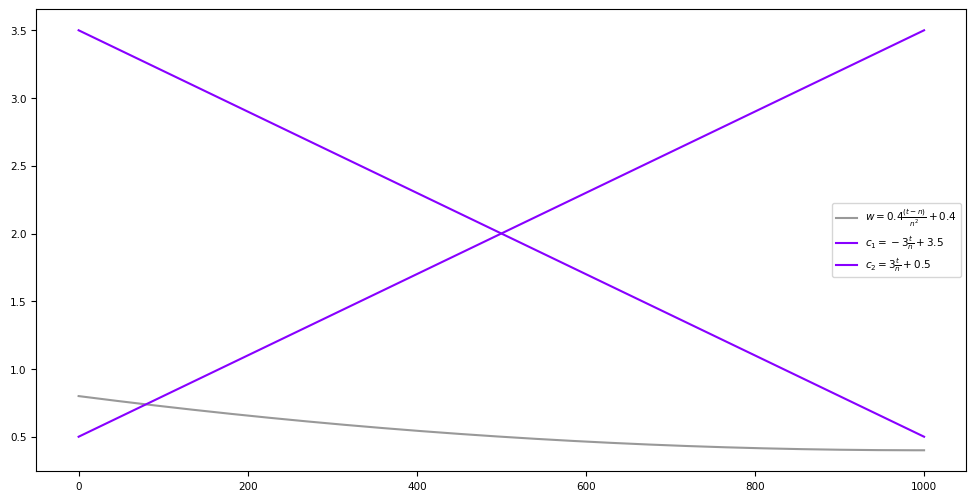

In [8]:
import os
import glob
import shutil

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter




def make_gif_from_folder(folder, out_file_path, remove_folder=True):
    files = os.path.join(folder, '*.png')
    img, *imgs = [Image.open(f) for f in sorted(glob.glob(files))]
    img.save(fp=out_file_path, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)
    shutil.rmtree(folder, ignore_errors=True)



plt.rcParams['figure.figsize'] = [12, 6] # default = [6.0, 4.0]
plt.rcParams['figure.dpi']     = 100     # default = 72.0
plt.rcParams['font.size']      = 7.5     # default = 10.0

cmap = cm.colors.LinearSegmentedColormap.from_list('Custom',
                                                   [(0, '#2f9599'),
                                                    (0.45, '#eee'),
                                                    (1, '#8800ff')], N=256)


def plot_2d_pso(meshgrid, function, particles=None, velocity=None, normalize=True, color='#000', ax=None):
    X_grid, Y_grid = meshgrid
    Z_grid = function(X_grid, Y_grid)
    # get coordinates and velocity arrays
    if particles is not None:
        X, Y = particles.swapaxes(0, 1)
        Z = function(X, Y)
        if velocity is not None:
            U, V = velocity.swapaxes(0, 1)
            if normalize:
                N = np.sqrt(U**2+V**2)
                U, V = U/N, V/N

    # create new ax if None
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1, projection='3d')

    # add contours and contours lines
    ax.contour(X_grid, Y_grid, Z_grid, levels=30, linewidths=0.5, colors='#999')
    cntr = ax.contourf(X_grid, Y_grid, Z_grid, levels=30, cmap=cmap, alpha=0.7)
    if particles is not None:
        ax.scatter(X, Y, color=color)
        if velocity is not None:
            ax.quiver(X, Y, U, V, color=color, headwidth=2, headlength=2, width=5e-3)

    # add labels and set equal aspect ratio
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(np.min(X_grid), np.max(X_grid))
    ax.set_ylim(np.min(Y_grid), np.max(Y_grid))
    ax.set_aspect(aspect='equal')


def plot_3d_pso(meshgrid, function, particles=None, velocity=None, normalize=True, color='#000', ax=None):
    X_grid, Y_grid = meshgrid
    Z_grid = function(X_grid, Y_grid)
    # get coordinates and velocity arrays
    if particles is not None:
        X, Y = particles.swapaxes(0, 1)
        Z = function(X, Y)
        if velocity is not None:
            U, V = velocity.swapaxes(0, 1)
            W = function(X + U, Y + V) - Z

    # create new ax if None
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1, projection='3d')

    # Plot the surface.
    surf = ax.plot_surface(X_grid, Y_grid, Z_grid, cmap=cmap,
                           linewidth=0, antialiased=True, alpha=0.7)
    ax.contour(X_grid, Y_grid, Z_grid, zdir='z', offset=0, levels=30, cmap=cmap)
    if particles is not None:
        ax.scatter(X, Y, Z, color=color, depthshade=True)
        if velocity is not None:
            ax.quiver(X, Y, Z, U, V, W, color=color, arrow_length_ratio=0., normalize=normalize)

    len_space = 10
    # Customize the axis
    max_z = (np.max(Z_grid) // len_space + 1).astype(np.int) * len_space
    ax.set_xlim3d(np.min(X_grid), np.max(X_grid))
    ax.set_ylim3d(np.min(Y_grid), np.max(Y_grid))
    ax.set_zlim3d(0, max_z)
    ax.zaxis.set_major_locator(LinearLocator(max_z // len_space + 1))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    # Rmove fills and set labels
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('f(X, Y)')

    # Add a color bar which maps values to colors.
    # fig.colorbar(surf)


if __name__ == '__main__':
    N = 1000
    t = np.arange(0, N + 1)
    w = (0.4 / N**2) * (t - N) ** 2 + 0.4
    c_1 = -3 * t / N + 3.5
    c_2 =  3 * t / N + 0.5

    plt.plot(t, w, color='#999', label=r'$w = 0.4\frac{(t - n)}{n^2} + 0.4$')
    plt.plot(t, c_1, color='#80f', label=r'$c_1 = -3\frac{t}{n} + 3.5$')
    plt.plot(t, c_2, color='#80f', label=r'$c_2 = 3\frac{t}{n} + 0.5$')
    plt.legend()
    plt.show()

#Plot init

/tmp/ipykernel_10464/1454838188.py:96: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_z = (np.max(Z_grid) // len_space + 1).astype(np.int) * len_space


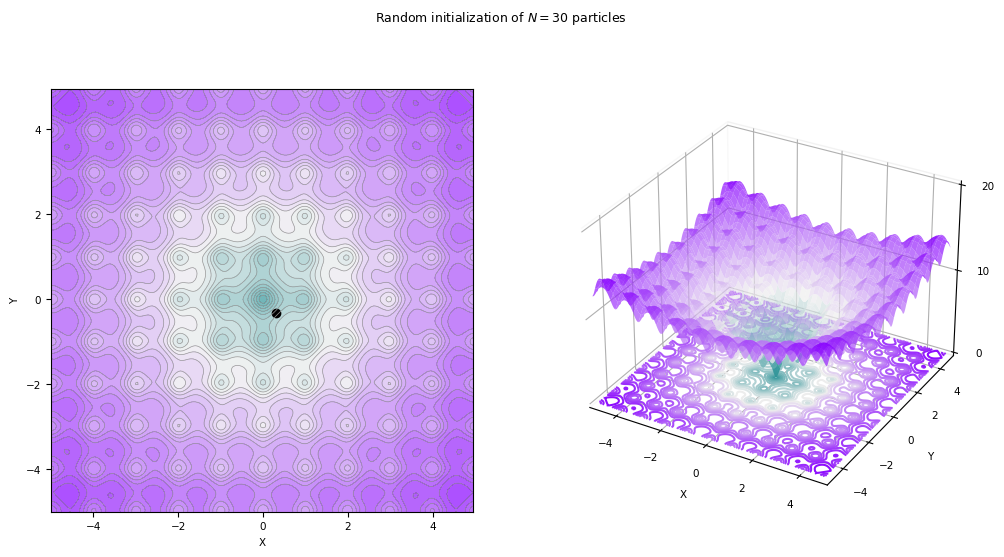

In [29]:
import numpy as np
import matplotlib.pyplot as plt

#from utils import plot_2d_pso, plot_3d_pso

n_particles = 1

# Make range grid
X = np.arange(-5, 5, 0.05)
Y = np.arange(-5, 5, 0.05)
meshgrid = np.meshgrid(X, Y)
f = lambda x, y: -20 * np.exp(-0.2 * np.sqrt(0.5 * (x ** 2 + y ** 2))) - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))) + 20 + np.e
particles = np.random.uniform(-5, 5, (n_particles, 2))
velocity = None
save_path = '0_particle.png'
# save_path = None

fig = plt.figure()
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot_3d_pso(meshgrid, f, particles, velocity, ax=ax)
ax = fig.add_subplot(1, 2, 1)
plot_2d_pso(meshgrid, f, particles, velocity, ax=ax)
fig.suptitle(r'Random initialization of $N=30$ particles')


if save_path is not None:
    plt.savefig(save_path)
else:
    plt.show()

#Plot run

[9.722252927489349, 2.6653135103876946, 0.2662574959964421, 0.1344198934626033, 0.09985177973375459, 0.01794698714924481, 0.01729071219968903, 0.0036036732497994883, 0.0029219465078900164, 0.00190533803241566, 0.0008926260853567847, 0.0003058822428347874, 9.72710439381963e-05, 8.227377696856664e-05, 5.384533976071637e-05, 1.1381900016704805e-05, 1.0666021897254296e-05, 3.072649079616241e-06, 2.620601098346498e-06, 3.6377281675825657e-07, 1.8518242983489586e-07, 1.8518242983489586e-07, 1.1921472564679902e-07, 3.123796732396045e-08, 3.109156354597076e-08, 1.7724272272090502e-08, 5.61329160930768e-09, 5.289795712570822e-09, 2.5401836190042104e-09, 9.922946908602626e-10, 4.906763884093834e-10, 2.841322732649587e-10, 1.741153887735436e-10, 8.947198537612167e-11, 5.85278492337693e-11, 1.0900169655769787e-11, 1.0900169655769787e-11, 4.412914478280072e-12, 3.997246977860414e-12, 1.0627054791711998e-12, 4.1255887595070817e-13, 4.1255887595070817e-13, 2.7755575615628914e-13, 9.992007221626409e-1

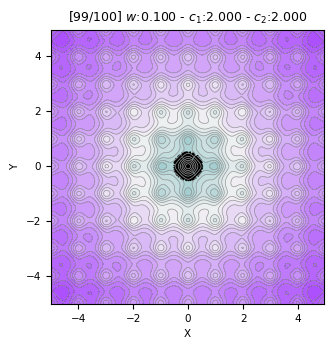

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt

# from PSO import PSO
# from utils import plot_2d_pso, plot_3d_pso, make_gif_from_folder

n_particles = 100

# Make range grid
X = np.arange(-5, 5, 0.05)
Y = np.arange(-5, 5, 0.05)
meshgrid = np.meshgrid(X, Y)


f = lambda x, y: -20 * np.exp(-0.2 * np.sqrt(0.5 * (x ** 2 + y ** 2))) - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))) + 20 + np.e

def fitness_function(pos):
    x, y = pos.swapaxes(0, 1)
    return f(x, y)


particles = np.random.uniform(-5, 5, (n_particles, 2))
velocities = (np.random.random((n_particles, 2)) - 0.5) / 10

pso_1 = PSO(particles.copy(), velocities.copy(), fitness_function, w=0.1, c_1=2.0, c_2=2.0, auto_coef=False)


root = 'src/'
filename = '_tmp.gif'
save = True

if save:
    tmp_dir = os.path.join(root, '_tmp')
    if not os.path.exists(tmp_dir):
        os.makedirs(tmp_dir)

fig = plt.figure()

while pso_1.next():
    # pso_2.next()
    # pso_3.next()
    fig.clear()
    save_path = None if not save else os.path.join(tmp_dir, f'{pso_1.iter:05d}.png')

    # ax = fig.add_subplot(1, 2, 2, projection='3d')
    # plot_3d_pso(meshgrid, f, pso.particles, pso.velocities, ax=ax)
    ax = fig.add_subplot(1, 3, 1)
    plot_2d_pso(meshgrid, f, pso_1.particles, pso_1.velocities, ax=ax)
    ax.set_title(str(pso_1))

    # ax = fig.add_subplot(1, 3, 2)
    # plot_2d_pso(meshgrid, f, pso_2.particles, pso_2.velocities, ax=ax)
    # ax.set_title(str(pso_2))

    # ax = fig.add_subplot(1, 3, 3)
    # plot_2d_pso(meshgrid, f, pso_3.particles, pso_3.velocities, ax=ax)
    # ax.set_title(str(pso_3))


    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)

make_gif_from_folder(tmp_dir, os.path.join(root, filename))
print(pso_1.extremums)



Мат. ожидание и дисперсия

In [28]:

# Исходная функция
f = lambda x, y: -20 * np.exp(-0.2 * np.sqrt(0.5 * (x ** 2 + y ** 2))) - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))) + 20 + np.e

# ПРОлучение массива значений
extremums = []
for el in pso_1.extremums:
    if el != float('-Inf'):
        extremums.append(el)
print(extremums)

print("VAR: ", np.var(extremums))
print("MEAN: ", np.mean(extremums))

[9.722252927489349, 2.6653135103876946, 0.2662574959964421, 0.1344198934626033, 0.09985177973375459, 0.01794698714924481, 0.01729071219968903, 0.0036036732497994883, 0.0029219465078900164, 0.00190533803241566, 0.0008926260853567847, 0.0003058822428347874, 9.72710439381963e-05, 8.227377696856664e-05, 5.384533976071637e-05, 1.1381900016704805e-05, 1.0666021897254296e-05, 3.072649079616241e-06, 2.620601098346498e-06, 3.6377281675825657e-07, 1.8518242983489586e-07, 1.8518242983489586e-07, 1.1921472564679902e-07, 3.123796732396045e-08, 3.109156354597076e-08, 1.7724272272090502e-08, 5.61329160930768e-09, 5.289795712570822e-09, 2.5401836190042104e-09, 9.922946908602626e-10, 4.906763884093834e-10, 2.841322732649587e-10, 1.741153887735436e-10, 8.947198537612167e-11, 5.85278492337693e-11, 1.0900169655769787e-11, 1.0900169655769787e-11, 4.412914478280072e-12, 3.997246977860414e-12, 1.0627054791711998e-12, 4.1255887595070817e-13, 4.1255887595070817e-13, 2.7755575615628914e-13, 9.992007221626409e-1

DE Algorithm

In [12]:
import numpy as np
import random

'''
def fit_fun(X):
    A = 1
    return 2 * A + X[0] ** 2 - A * np.cos(2 * np.pi * X[0]) + X[1] ** 2 - A * np.cos(2 * np.pi * X[1])
'''
def fit_fun(X):  # 适应函数
    return -np.abs(np.sin(X[0]) * np.cos(X[1]) * np.exp(np.abs(1 - np.sqrt(X[0] ** 2 + X[1] ** 2) / np.pi)))


class Unit:
    # 初始化
    def __init__(self, x_min, x_max, dim):
        self.__pos = np.array([x_min + random.random()*(x_max - x_min) for i in range(dim)])
        self.__mutation = np.array([0.0 for i in range(dim)])  # 个体突变后的向量
        self.__crossover = np.array([0.0 for i in range(dim)])  # 个体交叉后的向量
        self.__fitnessValue = fit_fun(self.__pos)  # 个体适应度

    def set_pos(self, i, value):
        self.__pos[i] = value

    def get_pos(self):
        return self.__pos

    def set_mutation(self, i, value):
        self.__mutation[i] = value

    def get_mutation(self):
        return self.__mutation

    def set_crossover(self, i, value):
        self.__crossover[i] = value

    def get_crossover(self):
        return self.__crossover

    def set_fitness_value(self, value):
        self.__fitnessValue = value

    def get_fitness_value(self):
        return self.__fitnessValue


class DE:
    def __init__(self, dim, size, iter_num, x_min, x_max, best_fitness_value=float('Inf'), F=0.5, CR=0.8):
        self.F = F
        self.CR = CR
        self.dim = dim  # 维度
        self.size = size  # 总群个数
        self.iter_num = iter_num  # 迭代次数
        self.x_min = x_min
        self.x_max = x_max
        self.best_fitness_value = best_fitness_value
        self.best_position = [0.0 for i in range(dim)]  # 全局最优解
        self.fitness_val_list = []  # 每次迭代最优适应值

        # 对种群进行初始化
        self.unit_list = [Unit(self.x_min, self.x_max, self.dim) for i in range(self.size)]

    def get_kth_unit(self, k):
        return self.unit_list[k]

    def set_bestFitnessValue(self, value):
        self.best_fitness_value = value

    def get_bestFitnessValue(self):
        return self.best_fitness_value

    def set_bestPosition(self, i, value):
        self.best_position[i] = value

    def get_bestPosition(self):
        return self.best_position

    # 变异
    def mutation_fun(self):
        for i in range(self.size):
            r1 = r2 = r3 = 0
            while r1 == i or r2 == i or r3 == i or r2 == r1 or r3 == r1 or r3 == r2:
                r1 = random.randint(0, self.size - 1)  # 随机数范围为[0,size-1]的整数
                r2 = random.randint(0, self.size - 1)
                r3 = random.randint(0, self.size - 1)
            mutation = self.get_kth_unit(r1).get_pos() + \
                       self.F * (self.get_kth_unit(r2).get_pos() - self.get_kth_unit(r3).get_pos())
            for j in range(self.dim):
                #  判断变异后的值是否满足边界条件，不满足需重新生成
                if self.x_min <= mutation[j] <= self.x_max:
                    self.get_kth_unit(i).set_mutation(j, mutation[j])
                else:
                    rand_value = self.x_min + random.random()*(self.x_max - self.x_min)
                    self.get_kth_unit(i).set_mutation(j, rand_value)

    # 交叉
    def crossover(self):
        for unit in self.unit_list:
            for j in range(self.dim):
                rand_j = random.randint(0, self.dim - 1)
                rand_float = random.random()
                if rand_float <= self.CR or rand_j == j:
                    unit.set_crossover(j, unit.get_mutation()[j])
                else:
                    unit.set_crossover(j, unit.get_pos()[j])

    # 选择
    def selection(self):
        for unit in self.unit_list:
            new_fitness_value = fit_fun(unit.get_crossover())
            if new_fitness_value < unit.get_fitness_value():
                unit.set_fitness_value(new_fitness_value)
                for i in range(self.dim):
                    unit.set_pos(i, unit.get_crossover()[i])
            if new_fitness_value < self.get_bestFitnessValue():
                self.set_bestFitnessValue(new_fitness_value)
                for j in range(self.dim):
                    self.set_bestPosition(j, unit.get_crossover()[j])

    def update(self):
        for i in range(self.iter_num):
            self.mutation_fun()
            self.crossover()
            self.selection()
            self.fitness_val_list.append(self.get_bestFitnessValue())
        return self.fitness_val_list, self.get_bestPosition()

DE лучшая позиция:[8.055023475386012, -9.664590027841093]
DE Оптимальное решение:-19.208502567886757


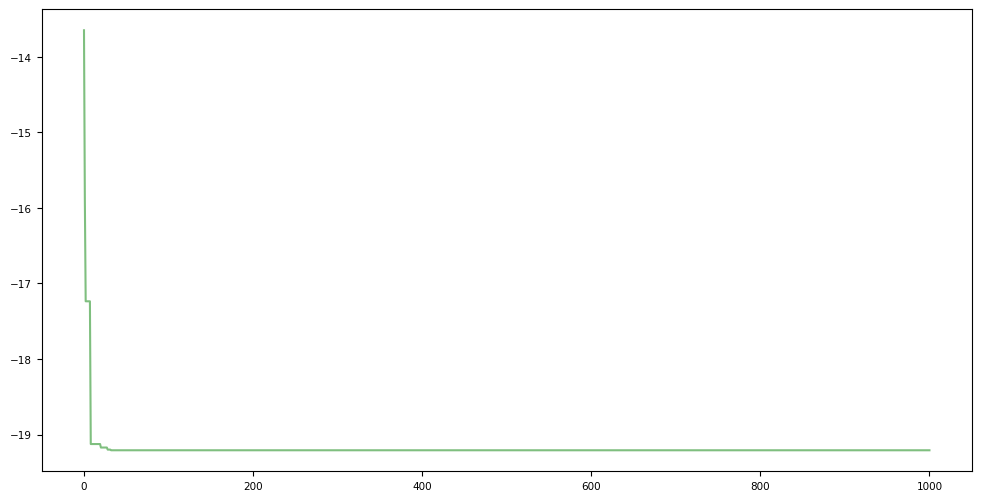

In [13]:
import matplotlib.pyplot as plt
import numpy as np

dim = 2
size = 15
iter_num = 1000
x_max = 10

de = DE(dim, size, iter_num, -x_max, x_max)
fit_var_list, best_pos = de.update()
print("DE лучшая позиция:" + str(best_pos))
print("DE Оптимальное решение:" + str(fit_var_list[-1]))
plt.plot(np.linspace(0, iter_num, iter_num), fit_var_list, c="GREEN", alpha=0.5)
plt.show()